In [1]:
# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# 1. Definition

## 1.1. Project Overview

**Student provides a high-level overview of the project in layman’s terms. Background information such as the problem domain, the project origin, and related data sets or input data is given.**

In its bi-yearly release, the *Bereau of Labor Statistics* published last september [a document](https://www.bls.gov/news.release/pdf/tenure.pdf) showing that wage and salary workers remain in the same job for about 4.2 years on average. For any given company, it is important to ensure that talents that are hired, trained, and invested on are motivated to stay in the company to help it grow and florish. It is important for the HR department of each company to study the various reasons because of which its employees are leaving prematurely. Then, based on these identified reasons, the HR department can develop various techniques, methods, and programs to enhance their employee tenure.

Ludovic Benistant uploaded [a dataset](https://www.kaggle.com/ludobenistant/hr-analytics) on [kaggle](https://www.kaggle.com/) that helps in studying the reasons behind some employees leaving their company. The dataset includes information about 15 thousand employees including whether they left their company or not in the last year.

The purpose of this report is to study this dataset and derive some important information out of it.

## 1.2. Problem Statement

**The problem which needs to be solved is clearly defined. A strategy for solving the problem, including discussion of the expected solution, has been made.**

The statement of the problem at hand is summarized by two main points:

1. Based on the given [dataset](https://www.kaggle.com/ludobenistant/hr-analytics), develop a model that is capable of identifying employees at risk of leaving the company. This can help the HR department in investing more time on those specific employees at risk of leaving and work on them on a case-by-case bases.

2. Extract the reasons based on which employees are leaving the company. This can help the HR department in developing company wide programs to help improve the employee tenure.

## 1.3. Metrics

**Metrics used to measure performance of a model or result are clearly defined. Metrics are justified based on the characteristics of the problem.**

For the model to be built based on the provided dataset, it is important to use metric that emphasis on both accuracy and precision:

1. Accuracy: Accuracy of the model is important because the HR department would want to identify a good percentage of those at risk of leaving. Having a model with good accuracy would result in identifying that required good percentage.
2. Precision: While it is important to identify those in need for motivation to stay in the company, it is important for the HR department to not waste time on those who are actually not at risk of leaving the company. Having good precision means that HR department is focusing more energy on those who really need help.

A good metric to capture this need is the F Score (aka F1 Score). F Score gives a metric that is balanced between both accuracy and precision. It is calculated according to the following formula:

$$F1 = 2 \frac{Accuracy . Precision}{Accuracy + Precision}$$


# 2. Data Analysis

Now that we have define the problem along with its metric, we can jump heads-first into the dataset to start analyzing it and cleaning it.

## 2.1. Data Wrangling

First of all, we start by wrangling the data from the csv file:

In [2]:
# Read data
from pandas import read_csv
df = read_csv('hr.csv')

# Display top rows
print(df.head())

   satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  left  promotion_last_5years  sales  \
0                   3              0     1                      0  sales   
1                   6              0     1                      0  sales   
2                   4              0     1                      0  sales   
3                   5              0     1                      0  sales   
4                   3              0     1                      0  sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4 

## 2.2. Label Extraction

As we can see from the sample of the dataset above, the label of our dataset is in the column *left*. Let's check that all values for label are valid:

In [3]:
# Check possible values for label in the dataset
print(set(df.left))

set([0, 1])


As we can see, all data for label are valid. Knowing that, we can now extract the label from the dataset:

In [4]:
# Extract features and label from dataset
y_all = df.left
X_all = df.drop('left', 1)

## 2.3. Clean Features

### 2.3.1. Feature Names

One thing we can notice from the sample of the dataset is that some columns have typo-mistakes. We can start by sorting these out to ensure clean titles of our features

In [5]:
# fix some typos
X_all.rename(columns = {'average_montly_hours': 'average_monthly_hours',
                        'time_spend_company': 'time_spent_company',
                        'Work_accident': 'work_accident'},
             inplace=True)

From the [source](https://www.kaggle.com/ludobenistant/hr-analytics) of the dataset we can identify each column to represent the following:

1. satisfaction_level: Employee satisfaction level
2. last_evaluation: Employee satisfaction from last evaluation
3. number_project: Number of projects
4. average_monthly_hours: Average monthly hours
5. time_spent_company: Time spent at the company
6. work_accident: Whether they have had a work accident
7. promotion_last_5years: Whether they have had a promotion in the last 5 years
8. sales: Department where employee work
9. salary: Salary level

From the above, it looks like the column-name *sales* seems off. Therefore, we change it to *department* so that it is more representative of the actual column:

In [6]:
# Rename sales column to be more representative
X_all.rename(columns = {'sales': 'department'}, inplace=True)

### 2.3.2. Feature Values

Also, from the above sample of data, we can see that two columns are actually catagorical and using string of characters as catagories: *department* and *salary*. We can start by checking the available catagories for each feature along with their percentage:

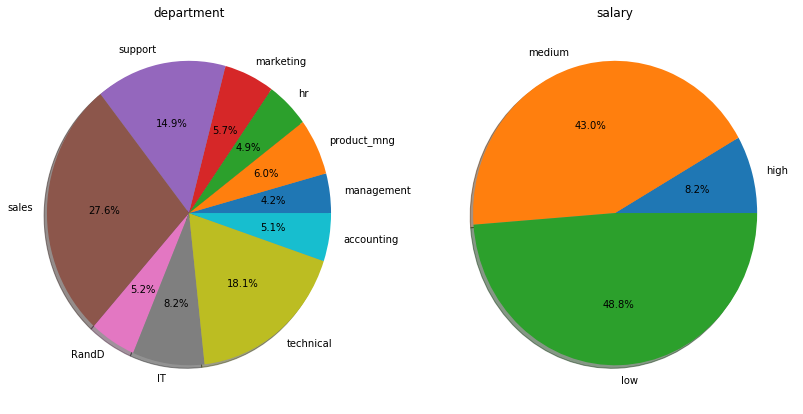

In [7]:
def draw_pie_chart(X, ax):
    # Extract unique values for X and their counts
    from collections import Counter
    c = Counter(X)
    values = c.keys()
    counts = c.values()
    
    # Draw a pie chart representing percentage of values
    ax.pie(counts, labels=values, autopct='%1.1f%%', shadow=True)
    ax.set_title(X.name)

# Create subplots for the two pie-charts
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Draw the two pie-charts for department and salary
draw_pie_chart(X_all.department, ax1)
draw_pie_chart(X_all.salary, ax2)

It seems that all catagories are valid as well as available with an impactful percentage.

Based on that, we can go ahead and create a dummy column for each catagory. This is done because most algorithms for classification can't deal with non-numerical data. We could simply map these catagories to numerical data; however, this would imply relationship between different catagories that is actually non-existent. A better solution is to create dummy columns for each catagory and fill it with 1 only when that catagory exists. This is done as follows:

In [8]:
# Create dummy columns from department and salary
from pandas import get_dummies
for col, col_data in X_all.iteritems():
    if col_data.dtype == object:
        # Get dummy columns
        new_data = get_dummies(col_data, prefix=col)
        
        # Add dummy columns to features
        X_all = X_all.join(new_data)
        
        # Remove original column from features
        X_all = X_all.drop(col, 1)

Now, let's move to look at features with binary data and data that are represented with specific sensible range of integer numbers: *number_project*, *average_monthly_hours*, *time_spent_company*, *work_accident*, and *promotion_last_5years*. Let's check if all values are valid in there:

In [9]:
for col in ['number_project', 'average_monthly_hours', 'time_spent_company', 'work_accident', 'promotion_last_5years']:
    print("{}: {}".format(col, set(X_all[col])))

number_project: set([2, 3, 4, 5, 6, 7])
average_monthly_hours: set([96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 2

Everything looks acceptable with these features.

Now, let's look at a summery of the features to ensure everything is good with the numerical features

In [10]:
print(X_all.describe())

       satisfaction_level  last_evaluation  number_project  \
count        14999.000000     14999.000000    14999.000000   
mean             0.612834         0.716102        3.803054   
std              0.248631         0.171169        1.232592   
min              0.090000         0.360000        2.000000   
25%              0.440000         0.560000        3.000000   
50%              0.640000         0.720000        4.000000   
75%              0.820000         0.870000        5.000000   
max              1.000000         1.000000        7.000000   

       average_monthly_hours  time_spent_company  work_accident  \
count           14999.000000        14999.000000   14999.000000   
mean              201.050337            3.498233       0.144610   
std                49.943099            1.460136       0.351719   
min                96.000000            2.000000       0.000000   
25%               156.000000            3.000000       0.000000   
50%               200.000000           

From the summery above, it seems everything is good.

With that, our features now are clean and ready to be used.

In [11]:
features = X_all.columns

print(X_all.head())

   satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   time_spent_company  work_accident  promotion_last_5years  department_IT  \
0                   3              0                      0              0   
1                   6              0                      0              0   
2                   4              0                      0              0   
3                   5              0                      0              0   
4                   3              0                      0              0   

   department_RandD  department_accounting  

## 2.4. Statistics

To better understand the data at hand, let's calculate some relevant statistics that could help us in later steps:

Number of Features:              20
Number of datapoints:            14,999


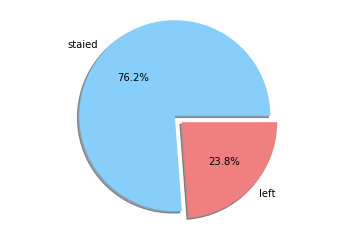

In [12]:
n_features = len(features)
n_datapoints = len(y_all)

print("Number of Features:              {}".format(n_features))
print("Number of datapoints:            {:,}".format(n_datapoints))

# Draw a pie chart representing percentage of label
import matplotlib.pyplot as plt
labels = ['staied', 'left']
label_counts = [len(y_all[y_all == label]) for label in [0, 1]]
label_colors = ['lightskyblue', 'lightcoral']
explode = (0, 0.1)
plt.pie(label_counts, explode=explode, labels=labels, colors=label_colors, autopct='%1.1f%%', shadow=True)
plt.axis('equal')
plt.show()

From these statistics, we can infer the following:

1. Number of features is high. We most likely will end up using some feature reduction/transformation technique
2. Percentage of True in label is low. We will need to take that into consideration in the various steps of developing a model that generalizes the dataset (Ex: we should ensure stratifying data when dividing it into training and testing sets)

While studying data, it is important also to look at the distribution of non-binary data. This could give us some insights about the structure of the data.

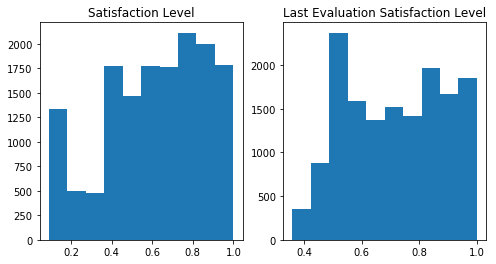

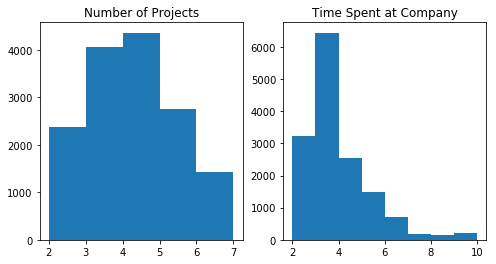

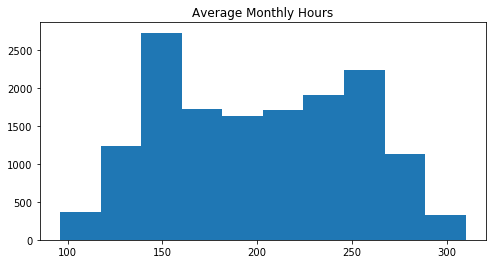

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.hist(X_all.satisfaction_level)
plt.title("Satisfaction Level")

plt.subplot(1, 2, 2)
plt.hist(X_all.last_evaluation)
plt.title("Last Evaluation Satisfaction Level")
plt.show()

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.hist(X_all.number_project, bins=5)
plt.title("Number of Projects")

plt.subplot(1, 2, 2)
plt.hist(X_all.time_spent_company, bins=8)
plt.title("Time Spent at Company")
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(X_all.average_monthly_hours)
plt.title("Average Monthly Hours")
plt.show()

From the above histograms, we can conclude the following:

1. Majority of employees scored above 0.4 in their current and previous satisfaction level
2. Majority of employees spent less than 5 years.
3. The distribution for number of projects looks like a normal distribution.
4. The distribution for time spent at company is skewed right. In other words, there are more employees who spent less than the average time spent for all employees.
5. The distribution for the average monthly hours seem to have two peeks at 150 and 250. It looks like these two peeks represent full-time and part-time employees.

## 2.5. Train-Test Split

It is important before embarking on creating a model that generalizes the dataset at hand to split our dataset into two. By building the model based on the first fold of the split, we can test it using the second fold to ensure that it generalizes well to the non-seen values in the real world.

However, while splitting it is important to ensure the split captures the unbalanced labels we have. Therefore, we enable stratification of the split as shown below:

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.1, stratify=y_all, random_state=0)

n_train = len(y_train)
n_test = len(y_test)
print("Number of Training points:              {}".format(n_train))
print("Number of Testing points:               {}".format(n_test))
print("% leaving company in Training set:      {0:.2f}%".format(100.0 * len(y_train[y_train == 1])/n_train))
print("% leaving company in Testing set:       {0:.2f}%".format(100.0 * len(y_test[y_test == 1])/n_test))

Number of Training points:              13499
Number of Testing points:               1500
% leaving company in Training set:      23.81%
% leaving company in Testing set:       23.80%


## 2.6. Data Exploration

Before moving on to create a model based on the dataset, we can first explore that dataset and see how each feature affects whether an employee leaves or not. This will help us in two ways:

1. It helps with extracting the reasons based on which employees are leaving the company which is the second problem in the problem definition section (Section 1.2).
2. It helps in creating a benchmark model that we can use to check against our created model.

### 2.6.1. Effect of Satisfaction Level

First, let's look at the satisfaction level of employees. For ease of visualization, we will divide the numbers provided by employees to four catagories based on the percentiles of the satisfaction_level column:

In [15]:
print(X_train.satisfaction_level.describe())

count    13499.000000
mean         0.612899
std          0.248995
min          0.090000
25%          0.440000
50%          0.640000
75%          0.820000
max          1.000000
Name: satisfaction_level, dtype: float64


1. Very Poor: 0 < satisfaction_level ≤ 0.44
2. Poor: 0.44 < satisfaction_level ≤ 0.64
3. Good: 0.64 < satisfaction_level ≤ 0.82
4. Very Good: 0.82 < satisfaction_level ≤ 1.00

Based on that we can get the following percentage of employees leaving for each satisfaction_level

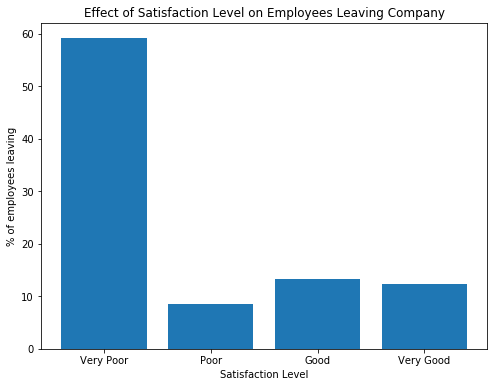

In [16]:
def satisfaction_level_catagory(val):
    if val < 0 or val > 1:
        raise ValueError("Value out of range: ", val)
    elif val <= 0.44:
        return "Very Poor"
    elif val <= 0.64:
        return "Poor"
    elif val <= 0.82:
        return "Good"
    else:
        return "Very Good"

# Get feature vector in catagory form
X_satisfaction_level = X_train.satisfaction_level.apply(satisfaction_level_catagory)

# mean of vector of zeros and ones gives you the fraction of 1's in that vector
from numpy import mean
x_axis = ['Very Poor', 'Poor', 'Good', 'Very Good']
y_axis = [100.0*mean(y_train[X_satisfaction_level == val]) for val in x_axis]

import matplotlib.pyplot as plt
from numpy import arange
plt.figure(figsize=(8,6))
plt.bar(arange(len(x_axis)), y_axis, align='center')
plt.xticks(arange(len(x_axis)), x_axis)
plt.ylabel('% of employees leaving')
plt.xlabel('Satisfaction Level')
plt.title("Effect of Satisfaction Level on Employees Leaving Company")
plt.show()

As it could be seen from the bar-chart, employees who gave less than 0.44 in their satisfaction level have very high chance (around 60%) of leaving the company

### 2.6.2. Effect of Number of Projects

We move to see the effect of number of projects on employees. First, we know from previous sections that there are 6 different values for number of porjects (Section 2.3.2) and they distribution for these values follow normal distribution (Section 2.4).

In [17]:
print(set(X_train.number_project))

set([2, 3, 4, 5, 6, 7])


From that, we can divide those values into three catagories:

1. Low: 2 ≤ number_project ≤ 3
2. Medium: 4 ≤ number_project ≤ 5
3. High: 6 ≤ number_project ≤ 7

Based on that we can get the following percentage of employees leaving for each number_project

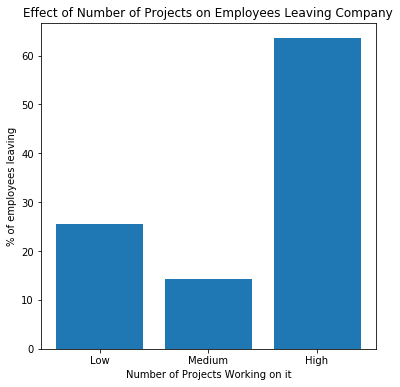

In [18]:
def number_project_catagory(val):
    if val < 2 or val > 7:
        raise ValueError("Value out of range: ", val)
    elif val <= 3:
        return "Low"
    elif val <= 5:
        return "Medium"
    else:
        return "High"

# Get feature vector in catagory form
X_number_project = X_train.number_project.apply(number_project_catagory)

# mean of vector of zeros and ones gives you the fraction of 1's in that vector
from numpy import mean
x_axis = ['Low', 'Medium', 'High']
y_axis = [100.0*mean(y_train[X_number_project == val]) for val in x_axis]

import matplotlib.pyplot as plt
from numpy import arange
plt.figure(figsize=(6,6))
plt.bar(arange(len(x_axis)), y_axis, align='center')
plt.xticks(arange(len(x_axis)), x_axis)
plt.ylabel('% of employees leaving')
plt.xlabel('Number of Projects Working on it')
plt.title("Effect of Number of Projects on Employees Leaving Company")
plt.show()

As we can see, employees who work on high number of projects have very high change (around 60%) of leaving the company.

### 2.6.3. Effect of Average Monthly Hours

Moving to the third feature to analyze, we can look at the average monthly hours and how it affects employees leaving/staying.

From the histogram shown in Section 2.4, we can see that there are two peeks (at 150 and 250) with flat area in between. Based on that, we can divide the population to three groups representing these three areas (the two peeks and the flat area in between). We can do that by looking at the 33 and 66 percentile:

In [19]:
from numpy import percentile
print("33 percentile: {}".format(percentile(X_train.average_monthly_hours, 33)))
print("66 percentile: {}".format(percentile(X_train.average_monthly_hours, 66)))

33 percentile: 168.0
66 percentile: 230.0


Based on that, we can divide the list of employees to three groups:

1. Short Working Hours: average_monthly_hours ≤ 168
2. Medium Working Hours: 168 < average_monthly_hours ≤ 230
3. Long Working Hours: 230 < average_monthly_hours

Based on that we can get the following percentage of employees leaving for each average_monthly_hours catagory.

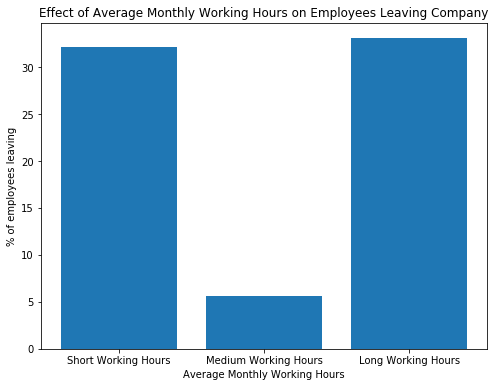

In [20]:
def average_monthly_hours_catagory(val):
    if val <= 168:
        return "Short Working Hours"
    elif val <= 230:
        return "Medium Working Hours"
    else:
        return "Long Working Hours"

# Get feature vector in catagory form
X_average_monthly_hours = X_train.average_monthly_hours.apply(average_monthly_hours_catagory)

# mean of vector of zeros and ones gives you the fraction of 1's in that vector
from numpy import mean
x_axis = ['Short Working Hours', 'Medium Working Hours', 'Long Working Hours']
y_axis = [100.0*mean(y_train[X_average_monthly_hours == val]) for val in x_axis]

import matplotlib.pyplot as plt
from numpy import arange
plt.figure(figsize=(8,6))
plt.bar(arange(len(x_axis)), y_axis, align='center')
plt.xticks(arange(len(x_axis)), x_axis)
plt.ylabel('% of employees leaving')
plt.xlabel('Average Monthly Working Hours')
plt.title("Effect of Average Monthly Working Hours on Employees Leaving Company")
plt.show()

As it could be seen from the bar-chart, employees with medium working hours have very low percentage of leaving the company.

### 2.6.4. Effect of Binary Features

Now, we can move to look at all the binary features at once. Since binary features has only two values, we can easily look at all of them at once in one bar-chart.

For ease of visualization, we will divide them into two figures.

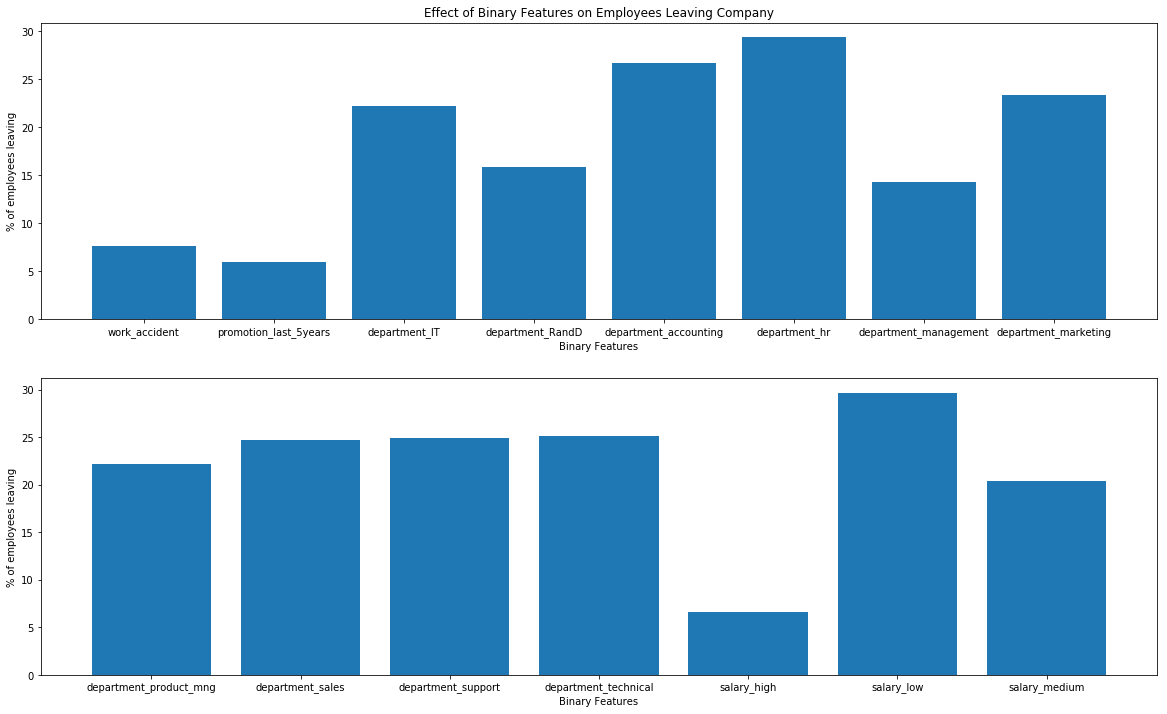

In [21]:
binary_features = [feature for feature in features if len(set(X_train[feature])) == 2]

# mean of vector of zeros and ones gives you the fraction of 1's in that vector
from numpy import mean 
x1_axis = binary_features[0:8]
y1_axis = [100.0*mean(y_train[X_train[feature] == 1]) for feature in x1_axis]

x2_axis = binary_features[8:15]
y2_axis = [100.0*mean(y_train[X_train[feature] == 1]) for feature in x2_axis]

import matplotlib.pyplot as plt
from numpy import arange
plt.figure(figsize=(20,12))
plt.subplot(2, 1, 1)
plt.bar(arange(len(x1_axis)), y1_axis, align='center')
plt.xticks(arange(len(x1_axis)), x1_axis)
plt.ylabel('% of employees leaving')
plt.xlabel('Binary Features')
plt.title("Effect of Binary Features on Employees Leaving Company")

plt.subplot(2, 1, 2)
plt.bar(arange(len(x2_axis)), y2_axis, align='center')
plt.xticks(arange(len(x2_axis)), x2_axis)
plt.ylabel('% of employees leaving')
plt.xlabel('Binary Features')
plt.show()

We can derive from the bar-chart the following:

1. Employees who had work accident are less likely to leave the company
2. Employees who got promoted in the last five years are less likely to leave the company
3. Employees who have high salary are less likely to leave the company.

## 2.7. Benchmark

From the data exploration done in the previous section, we can build a basic classifier that can be considered a benchmark based on which the actual model is compared.

From the data exploration, we found four outcomes:

1. Employees with satisfaction level less than or equal to 0.44 have high chance of leaving the company
2. Employees working on more than 5 projects have high chance of leaving the company
3. Employees having average monthly hours between 168 and 230 have low chance of leaving the company
4. Employees who had: a. work accident b. promoted in the last 5 years c. high salary, have low chance of leaving the company.

Ideally, the forth point should be divided into three seprate points. However, if we look at the percentage of employees belonging to these three catagories, we will find the following:

In [22]:
for feature in ['work_accident', 'promotion_last_5years', 'salary_high']:
    print("{:25}: {:5.2f}%".format(feature, 100.0*len(y_train[X_train[feature] == 1])/n_train))

work_accident            : 14.43%
promotion_last_5years    :  2.13%
salary_high              :  8.30%


These percentages are low compared to the percentage of employees belonging to the other three catagories. Because of that, we combined them into one point.

As we can see, there are two points pushing to classify an employee among the group at risk of leaving the company, and two points pushing in the other direction. Based on that we can build the following predictor:

1. Predictor checks for each of the four points mentioned above
2. For the first two points, we add 1 point for each condition satisfied representing a push towards classifying the employee at risk of leaving.
3. For the other two points, we subtract 1 point for each condition satisfied representing a push towards not classifying the employee at risk of leaving.
4. Any employee that ends with positive points is flagged at risk of leaving.

In [23]:
def predict(X):
    y = []
    for i, x in X.iterrows():
        cnt = 0
        if(x.satisfaction_level <= 0.44):
            cnt += 1
        if(x.number_project > 5):
            cnt += 1
        if(168 < x.average_monthly_hours and x.average_monthly_hours <= 230):
            cnt -= 1
        if(x.work_accident == 1 or x.promotion_last_5years == 1 or x.salary_high == 1):
            cnt -= 1
        
        if(cnt>=1):
            y.append(1)
        else:
             y.append(0)
    return y

Now, we can apply our metric of choice (f1 score) to the above predictor and see what we get.

In [24]:
from sklearn.metrics import f1_score
print(f1_score(y_test, predict(X_test)))

0.661676646707


With this benchmark at hand, we embark now on our quest to build a model that beats this score that we got by simply exploring the different features of the dataset in isolation.

# 3. Feature Engineering

In order to build a model or a learner that generalizes the dataset at hand, we need first to prepare our features for the training of this model/learner.

## 3.1. Feature Scaling

From the non-binary features that we have, two of them are already ranging between 0 and 1 (satisfaction_level and last_evaluation). There are other three features that have different ranges (number_project, average_monthly_hours, and time_spent_company). It is important to have all values for features in a standardized form. Having features with different scales could give an importance to a certain feature that is not reflective of real world. That's why, we start by making all features conform to the range [0, 1]:

In [25]:
# Create a copy of the feature dataframe
X_scaled = X_all.copy()

# Scale features that are out of 
from sklearn.preprocessing import MinMaxScaler
number_project_scaler = MinMaxScaler()
X_scaled.number_project = number_project_scaler.fit_transform(X_scaled.number_project.values.reshape(-1, 1))

average_monthly_hours_scaler = MinMaxScaler()
X_scaled.average_monthly_hours = average_monthly_hours_scaler.fit_transform(X_scaled.average_monthly_hours.values.reshape(-1, 1))

time_spent_company_scaler = MinMaxScaler()
X_scaled.time_spent_company = time_spent_company_scaler.fit_transform(X_scaled.time_spent_company.values.reshape(-1, 1))

C:\ProgramData\Anaconda3\envs\mlnd\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


## 3.2. Feature Transformation

So far, we have 20 features to be used in building our model. That's a high number of features; therefore, the next step is to have dimensionality reduction. This will be done in two ways:

1. Principle Component Analysis: To pick components in a lower dimension that would explain the maximum amount of variance in data
2. Feature Selection: To ensure the most important features are kept in the transformed feature set.

Even though, in the following two sections we will be choosing 2 principle components and 2 features in the transformed feature space, we will end up using cross-validation in choosing the optimal number of principle components and features. This will be done in a later section.

### 3.2.1. Principle Component Analysis

We start by creating a pca of just two components and fit it against our scaled data. Based on that, we can see the amount of explained varience by these two components

In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=0).fit(X_scaled)

# Components names indexing
components = ['component_{}'.format(i) for i in range(1,len(pca.components_)+1)]

from pandas import DataFrame
explained_variance = DataFrame(list(pca.explained_variance_) + [sum(pca.explained_variance_)],
                                  index = components + ['Total'],
                                  columns=['Explained Variance'])
print(explained_variance)

             Explained Variance
component_1            0.457600
component_2            0.237535
Total                  0.695135


As we can see, from just two dimensions, we can explain 69.5% of the variance in data.

Now, we move to understanding what each component actually represent with respect to the original features:

[<matplotlib.text.Text at 0xca4e6d8>, <matplotlib.text.Text at 0x99925f8>]

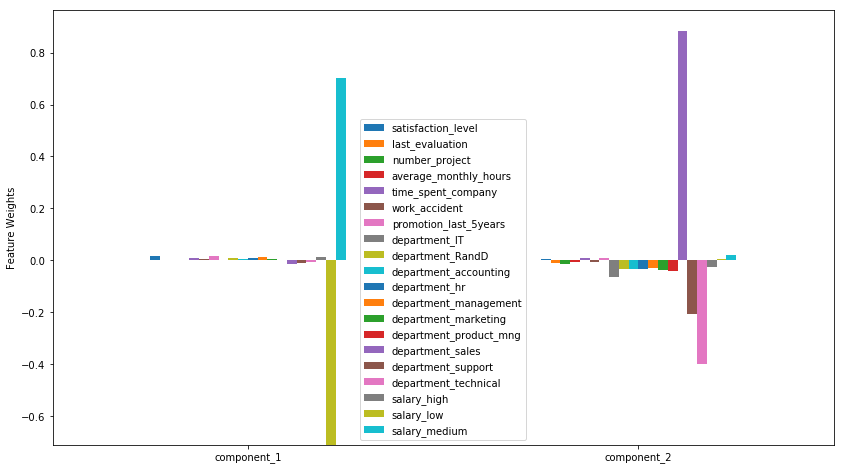

In [27]:
# PCA components
from pandas import DataFrame
pca_components = DataFrame(pca.components_, columns=X_scaled.columns, index=components)

# Create a bar plot visualization
fig, ax = plt.subplots(figsize = (14,8))

# Plot the feature weights as a function of the components
pca_components.plot(ax=ax, kind='bar');
ax.set_ylabel("Feature Weights")
ax.set_xticklabels(components, rotation=0)

From the bar-chart above, we can see that each component has emphasis on the following:

1. The first component represents focus on the salary of the employee whether it is low or medium. Positive values of this principle component represent medium salary, and negative values represent low salary.
2. The second component represents focus on the department of the employee and specifcally whether he/she is part of the sales, support, or technical departments. Positive values of this principle component represent employees in sales department and negative values represent employees in support or technical departments.

Based on that, we can translate our scaled feature space into these two principle components:

In [28]:
from pandas import DataFrame
X_pca = DataFrame(pca.transform(X_scaled), columns=components)

### 3.2.2. Feature Selection

While reducing the space of feature to the two principle components from the previous section, we can miss some important feature that has direct impact on the performance of our learner. Therefore, it would be benefitial to select two features from scaled feature space and include them in our transformed feature space:

In [29]:
from sklearn.feature_selection import SelectKBest
kbest = SelectKBest(k=2).fit(X_scaled, y_all)

from pandas import DataFrame
X_select = DataFrame(kbest.transform(X_scaled), columns=features[kbest.get_support(indices=True)])

### 3.2.3. Create the Transformed Feature Space

With PCA and feature selection done, we can now combine the two feature spaces in the transformed feature space

In [30]:
from pandas import concat
X_transform = concat([X_pca, X_select], axis=1)

# 4. Build Learner

With the feature space engineered and ready to be used to build our learner, we move ahead into building learners for our dataset.

## 4.1. Train-Test Split of Transformed Data

In Section 2.5, we discussed the importance of splitting the data into trainning and testing. In that section, we split the original *X_all* features. In this section, we apply the same train-test-split technique in order to help us build the learner.

In [31]:
from sklearn.model_selection import train_test_split
X_train_transform, X_test_transform, y_train_transform, y_test_transform = train_test_split(X_transform, y_all, 
                                                                                            test_size=0.1, 
                                                                                            random_state=0, 
                                                                                            stratify = y_all)

## 4.2. Candidate Learners

From the definition of the problem we are tackling in this report, we can conclude that it is not just important to build a model, it is important for the model to justify why it classifies a certain employee as being at risk of leaving the company. This is done to help the HR department in its quest to enhance employee tenure.

Based on that, we can conclude that the learners to be used should be white-box learners. In other words, they should provide both classification and reason behind the said classification. Because of that, we will be using:

1. K Nearest Neighbour: This learner can simply provide the K-nearest-neighbours based on which a classification was done. These neighbours are actually the old employees (from the training set) who left the company. Using those neighbours/employees, the HR department can further dig up the reasons why those employees left and help ensuring the issue is resolved with the employee at risk.
2. Decision Tree: This learner builds a tree that could be simply displayed to identify how a certain employee is classified at risk of leaving.

Note that the dimensionality reduction done in Section 3.2 comes in very handy with the KNN algorithm. It helps with what is known as the curse of dimensionality which indictes that as the number of dimensions increase, the volume of the space increases exponentially making the allocation of the k-nearest-neighbours very hard.

For this section, we won't pay much attention to the hyperparameters of the learners as we are just trying to build a basic learner. The hyperparameters will be tuned in a later section

### 4.2.1. KNN

Let's go ahead and train the first learner.

In [32]:
# Build Classifier
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier(n_neighbors=5)

# Train Classifier
clf_knn.fit(X_train_transform, y_train_transform)

# Predict
y_pred_knn = clf_knn.predict(X_test_transform)

# Find Score
from sklearn.metrics import f1_score
score_knn = f1_score(y_test_transform, y_pred_knn)
print(score_knn)

0.792243767313


This value of 0.79 for the f1_score is a very good improvement over the 0.66 of the benchmark model.

From this model, we can classify an employee and show the 5 closest employees based on which the classification was made:

In [33]:
# Choose the first employee in the test set
employee = X_test_transform.iloc[[0]]

# Display Employee
from IPython.display import display
print("Employee Chosen:")
display(X_all.loc[employee.index])

Employee Chosen:


,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spent_company,work_accident,promotion_last_5years,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium
11294,0.91,0.64,3,241,10,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [34]:
# Check prediction vs actual
print("Classification:")
print("Actual: {}, Prediction: {}".format(y_test_transform.iloc[[0]].values, clf_knn.predict(employee)))

Classification:
Actual: [0], Prediction: [0]


In [35]:
# Get k-nearest-neighbours to the chosen employee
distances, neighbours = clf_knn.kneighbors(employee)
distances, neighbours = (distances[0], neighbours[0])

# Convert from index in X_train_transform to the actual index of those neighbours
neighbours = X_train_transform.iloc[neighbours].index

# Print values
print("Nearest Neighbours/Employees:")
display(X_all.loc[neighbours])

Nearest Neighbours/Employees:


,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spent_company,work_accident,promotion_last_5years,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium
13505,0.91,0.64,3,241,10,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
13860,0.91,0.77,3,195,7,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
11649,0.91,0.77,3,195,7,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2449,0.91,0.70,3,132,4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
10475,0.91,0.66,3,208,4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


### 4.2.2. Decision Tree

Let's go ahead and train the second learner

In [36]:
# Build Classifier
from sklearn.tree import DecisionTreeClassifier
clf_dt = DecisionTreeClassifier(max_leaf_nodes=8, random_state=0)

# Train Classifier
clf_dt.fit(X_train_transform, y_train_transform)

# Predict
y_pred_dt = clf_dt.predict(X_test_transform)

# Find Score
from sklearn.metrics import f1_score
score_dt = f1_score(y_test_transform, y_pred_dt)
print(score_dt)

0.756589147287


This value of 0.76 for the f1_score is a very good improvement over the 0.66 of the benchmark model.

From this model, we can show the tree that is built and based on which any classification is done:

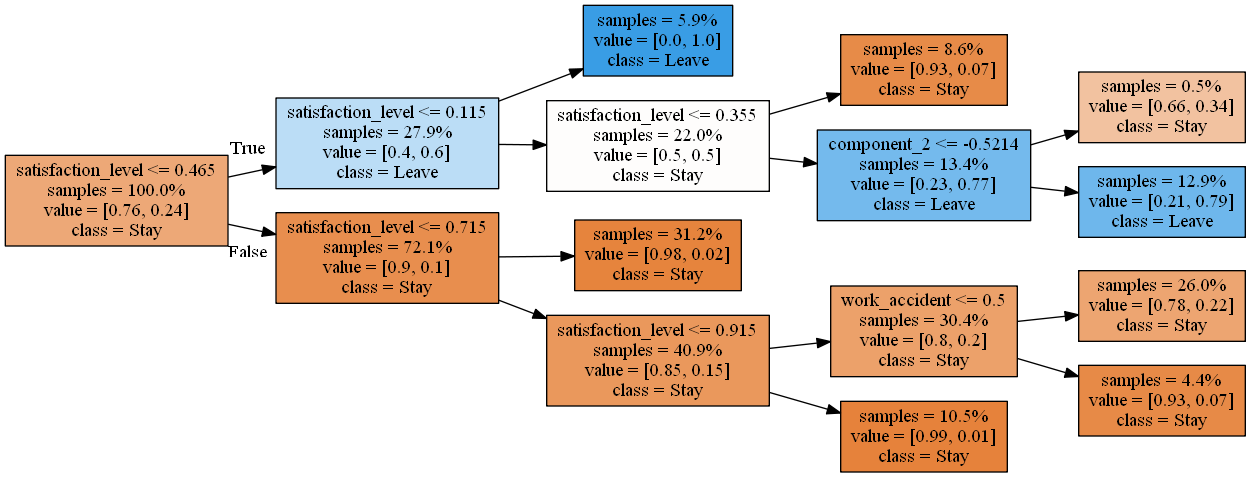

In [37]:
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from IPython.display import Image  
dot_data = export_graphviz(clf_dt,
                           feature_names=X_train_transform.columns,
                           class_names=['Stay', 'Leave'],
                           out_file=None,
                           rotate=True,
                           impurity=False,
                           proportion=True,
                           filled=True)
graph = graph_from_dot_data(dot_data)
Image(graph.create_png())

By tracking the tree above, the HR department can easily understand how each factor is causing a classification of an employee to be at risk or not.

## 4.3. Use Pipeline to get The Optimal Learner

In the previous section (Section 4.2.), we used two learners (KNN and Decision Tree) to model our dataset. The hyperparameters of these two learners were set randomly just to get a feel of what these learners can produce. 

Also, in Section 3.2, dimensionality reduction to 2 principle components and two selected features were chosen without checking what other values might have given us.

In this section, we use the power of pipeline and grid search cross-validation to find those optimal parameters:

In [38]:
# Build feature transformation estimator that combines PCA and Feature Selection
from sklearn.pipeline import FeatureUnion
features_transformation = FeatureUnion([('pca', pca), ('select', kbest)])

# Prepare a pipeline to sweep over possible values for feature transformation and learners
# Note: clf_dt is just place holder as the actual learner will be used based on grid search
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('features_transformation', features_transformation), ('learner', clf_dt)])

# Parameters to sweep
pca_n_components = [2, 3]
kbest_k = [1, 2, 3]
dt_max_leaf_nodes = [3, 8, 10, 20]
dt_min_samples_leaf = [0.01, 0.1, 1]
knn_n_neighbors = [1, 2, 5, 10]
knn_p = [1, 2, 3]

# Build the parameters grid for the grid search
param_grid = [
    {
        'features_transformation__pca__n_components': pca_n_components,
        'features_transformation__select__k': kbest_k,
        'learner': [clf_dt],
        'learner__max_leaf_nodes': dt_max_leaf_nodes,
        'learner__min_samples_leaf': dt_min_samples_leaf
    },
    {
        'features_transformation__pca__n_components': pca_n_components,
        'features_transformation__select__k': kbest_k,
        'learner': [clf_knn],
        'learner__n_neighbors': knn_n_neighbors,
        'learner__p': knn_p
    }
]

# Since the train-split in Section 4.1 is done after transformation, we need another split based on scaled data
from sklearn.model_selection import train_test_split
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_transform, y_all, 
                                                                                            test_size=0.1, 
                                                                                            random_state=0, 
                                                                                            stratify = y_all)

# Build the grid search
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipeline, param_grid=param_grid, scoring='f1')

# Sweep using the grid search and figure the best parameters for the pipeline
# Note: we use the 
grid.fit(X_train_scaled, y_train_scaled)

# Print Best Parameters
display(grid.best_params_)

{'features_transformation__pca__n_components': 2,
 'features_transformation__select__k': 3,
 'learner': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=1, p=1,
            weights='uniform'),
 'learner__n_neighbors': 1,
 'learner__p': 1}

With that, we can pick the best classifier and transformer:

In [39]:
best_clf = grid.best_estimator_.named_steps['learner']
best_feature_transformer = grid.best_estimator_.named_steps['features_transformation']
best_pipeline = grid.best_estimator_

## 4.4. Evaluate Final Learner

With the learner built in the previous section, we move to see how this learner performs on the testing set.

In [40]:
y_pred_pipeline = best_pipeline.predict(X_test_scaled)
print(f1_score(y_test_scaled, y_pred_pipeline))

0.900136798906


As it could be seen, having the parameter sweep enabled us to enhance the f1 score from 0.79 to 0.90.

With that, we have a learner that:

1. White-Box Learner: HR department can easily identify why a certain employee is classified in a certain manner.
2. Effective Learner: The learner has a high f1 score making it effective in both
    1. Correctly identifying employees at risk.
    2. Avoid miss-classifying an employee as being at risk while he/she is not.

# 5. Conclusion

All in all, we have started this report with a clear definition of a problem that is facing the HR department. The problem is manifisted in the fact that more and more talents are leaving the company after spending on their training. The report started with two promises:

1. Build a model/learner that can identify employees at risk of leaving the company
2. Provide the HR department with the reasons behind which employees are leaving the company.

Through out the report, the reasons for leaving the company were layed out in the form of:

1. Studying the effect of specific features and how they increase/decrease the probability of an employee leaving the company. Through that we identified the following:
    1. Employees with satisfaction level less than or equal to 0.44 have high chance of leaving the company
    2. Employees working on more than 5 projects have high chance of leaving the company
    3. Employees having average monthly hours between 168 and 230 have low chance of leaving the company
    4. Employees who had work accident have low chance of leaving the company.
    5. Employees who were promoted in the last 5 years have low chance of leaving the company
    6. Employees who have high salary have low chance of leaving the company
2. Building a decision tree based on which the reasons for leaving the company can be tracked
3. Building a KNN classifier which makes it easy to see why a certain employee is classified as being at risk of leaving.

In addition to providing all these insightful reasons for the HR department to enhance employee tenure, a model/learner was built that provides an effective classification of employees and whether they are at risk of leaving the company. To see how effective it is, we can look at the following pie chart which shows what are the percentages of:

1. True Negative: Identifying an employee as not being at risk of leaving correctly
2. True Positive: Identifying an employee as being at risk of leaving correctly
1. False Negative: Identifying an employee as not being at risk of leaving incorrectly
2. False Positive: Identifying an employee as being at risk of leaving incorrectly

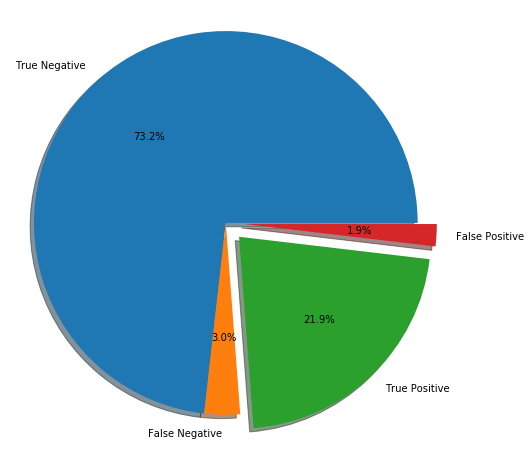

In [41]:
# Get Confusion Matrix and transform it to vector
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_scaled, y_pred_pipeline)
metrics_values = cm.reshape(1, -1)[0]

# Swap False Positive with True Positive for ease of visualization
metrics_values[2], metrics_values[3] = metrics_values[3], metrics_values[2]

metrics_names = ['True Negative', 'False Negative', 'True Positive', 'False Positive']
explode = (0, 0, 0.1, 0.1)
plt.figure(figsize=(8,8))
plt.pie(metrics_values, explode=explode, labels=metrics_names, autopct='%1.1f%%', shadow=True)
plt.axis('equal')
plt.show()

From this pie chart, we can see that:

1. The learner incorrectly classifies only 4.9% of all employees.
2. The learner misses 8% ($\frac{1.9}{1.9 + 21.9}$) of employees who are at risk.
3. The learner includes 4% ($\frac{3}{3 + 73.2}$) of employees who are not at risk.
4. From the set of employees that the HR department will be focusing on, only 12% ($\frac{3}{3 + 21.9}$) of them are actually not at risk of leaving.

With such low percentages, we can confidently conclude that the purpose of the report has been reached.